In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SALib
from SALib.plotting import bar
import seaborn as sns
# read Sobol' sensitivity indices as dataframe
from settings import SOBOL_DATA_DIR, FIGURE_DIR
from utils.Sobol_G_setting import set_sobol_g_func
from pandas.core.common import flatten

## Plot Sobol' SA with dummy parameter included

<Figure size 576x432 with 0 Axes>

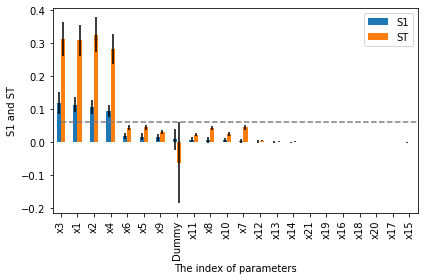

In [4]:
df = pd.read_csv(f'../output/sobol/Sobol_indices.csv', index_col = 'Unnamed: 0')
a, x, x_bounds, x_names, len_params, problem = set_sobol_g_func()

df_plot = pd.DataFrame()
df_plot.loc[:, 'S1'] = df[df.Type == 'S1']['result_5000'].values
df_plot.loc[:, 'S1_conf'] = df[df.Type == 'S1_conf']['result_5000'].values
df_plot.loc[:, 'ST'] = df[df.Type == 'ST']['result_5000'].values
df_plot.loc[:, 'ST_conf'] = df[df.Type == 'ST_conf']['result_5000'].values
threshold = df_plot.loc[21, 'ST'] + df_plot.loc[21, 'ST_conf']

df_plot.index = [* problem['names'], 'Dummy']
df_plot.sort_values(by='S1', ascending=False, inplace=True)
fig = plt.figure(figsize = (8, 6))
ax = bar.plot(df_plot)
# ax.set_xticklabels([* problem['names'], 'Dummy'])
ax.set_xlabel('The index of parameters')
ax.set_ylabel('S1 and ST')
plt.tight_layout()
plt.hlines(threshold, xmin=0, xmax=22, colors = 'grey', linestyle='--')
plt.savefig(f'../output/sobol/Sobol_dummy.png', format = 'png', dpi = 300)

## Plot the adaptive evaluation

In [92]:
from settings import *
df = {}
filename = ['fix_9'] #'fix_9', 'fix_17','fix_1', , 'fix_21', 'fix_10',
fpath = '../output/morris/latin_adaptive/'
for fn in filename:
    df[fn] = pd.read_csv(f'{fpath}{fn}.csv', index_col = 'Unnamed: 0').T.iloc[:500]
    df[fn].index = df[fn].index.astype('int')
    
mse = pd.read_csv(f'{fpath}mse.csv', index_col='Unnamed: 0')

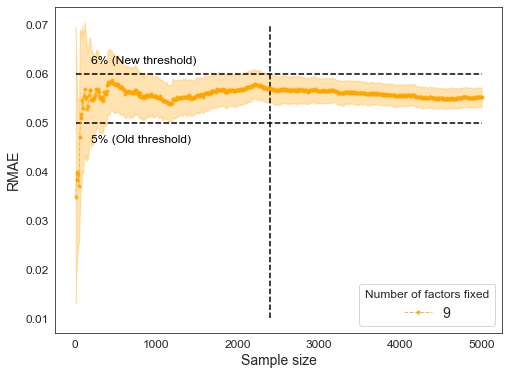

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
fs = 12
sns.set_style('white')
plt.rcParams['legend.title_fontsize'] = 12
lgd = [ii.split('_')[1] for ii in filename]
METRIC_NAME = [METRIC_NAME[0]]
metrics = [fn for fn in METRIC_NAME if not '_' in fn ]
for ii in range(len(metrics)):
    metric = metrics[ii]
    for fn in filename:
        df_plot = df[fn]
        logy = True if ii == 0 else False
        ax = df_plot.loc[:, metric].plot(kind='line', marker='o', linewidth=1, style='--', ms=3, ax = axes, alpha=0.8, logy=False, color='orange')
        ax.fill_between(df_plot.index, df_plot.loc[:, f'{metric}_lower'], df_plot.loc[:, f'{metric}_upper'], alpha = 0.3, color='orange')
    if ii == 0:
        ax.hlines(0.06, df_plot.index[0], df_plot.index[-1], linestyle = '--')
        ax.hlines(0.05, df_plot.index[0], df_plot.index[-1], linestyle = '--')
        ax.vlines(2400, 0.01, 0.07, linestyle = '--')
    else:
        ax.hlines(1.06, df_plot.index[0], df_plot.index[-1], linestyle = '--')
        ax.hlines(0.94, df_plot.index[0], df_plot.index[-1], linestyle = '--')
        
    ax.set_xlabel('Sample size', fontsize=14);
    ax.set_ylabel('RMAE', fontsize = 14);
    # print(ax.get_xticklabels())
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)
    ax.legend(lgd, title='Number of factors fixed', fontsize = 14, ncol=2, loc='lower right')
    ax.text(200, 0.062, '6% (New threshold)', fontsize=12, color='k')
    ax.text(200, 0.046, '5% (Old threshold)', fontsize=12, color='k')
plt.savefig('../output/figure/mae_adaptive_test.png', format = 'png', dpi = 300)


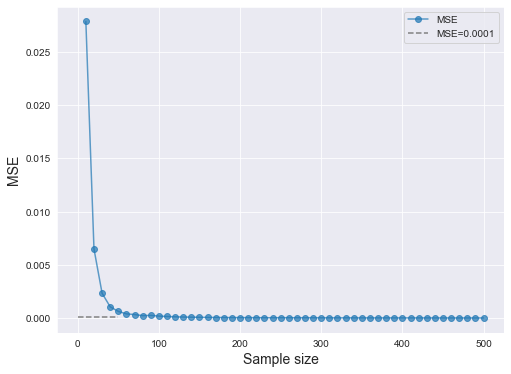

In [94]:
# Plot the MSE of the mean using variance and the sample size
sns.set_style('darkgrid')
ax = mse.iloc[:50].plot(legend=False, figsize = (8, 6), marker = 'o', alpha = 0.7)
ax.set_xlabel('Sample size', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
hlines_value = 0.0001
plt.hlines(hlines_value, xmin=0, xmax=50, colors='grey', linestyles='--')
ax.legend(['MSE', f'MSE={hlines_value}'])
# plt.savefig('../output/figure/mse_lhs.png', format = 'png', dpi = 300)

In [5]:
df['fix_9']['mae_upper'].iloc[230:240]

2310    0.060084
2320    0.060410
2330    0.060235
2340    0.060039
2350    0.060185
2360    0.060064
2370    0.059943
2380    0.059655
2390    0.059844
2400    0.059865
Name: mae_upper, dtype: float64

## Plot Figure 7 

In [44]:
from settings import *
df = {}
f_dir = '../output/sobol/compare/0.25/'
df_metric = pd.DataFrame(columns=METRIC_NAME)
metric_cols = df_metric.columns
for i in range(len(METRIC_NAME)):
    f_read = pd.read_csv('{}{}{}'.format(f_dir, METRIC_NAME[i], '.csv'))
    df_metric[metric_cols[i]] = f_read[f_read.columns[1]]
    

In [40]:
df_metric.index

Int64Index([4, 9, 11, 12, 15, 18], dtype='int64')

In [45]:
# obtain relative bias    
cols = df_metric.columns
col_upper = [col for col in cols if 'up' in col]
col_lower = [col for col in cols if 'low' in col]
for ii in range(len(col_upper)):
    df_metric[col_upper[ii]] = df_metric[col_upper[ii]] - df_metric[cols[ii]]
    df_metric[col_lower[ii]] = df_metric[cols[ii]] - df_metric[col_lower[ii]]

df_metric.fillna(value=0.0, inplace=True)
df_metric['ppmc'] = df_metric['ppmc'].apply(lambda x: 1 - x)
df_metric['var'] = df_metric['var'].apply(lambda x: np.abs(1 - x))
df_metric = df_metric.drop_duplicates('mae', keep='first')
# drop the first row due to RMAE > 0.40
df_metric = df_metric.iloc[:0:-1]
yerror = [[df_metric[col_lower[ii]].values, df_metric[col_upper[ii]].values] for ii in range(len(col_upper))]
x = df_metric.index
df_metric.index = ([str(21 - i) for i in x])


In [32]:
# import the analytic variance 
fvariance = np.loadtxt('../data/variance_frac.txt')
# total_variance = 2.755
index_fix = np.array([[20], [17, 9], [15, 16, 18], [14, 12, 13], 
                    [11], [9, 10], [8, 7, 6, 5, 4], [2, 3, 0, 1]])
variance_frac = fvariance[[len(list(flatten(index_fix[0:i+1])))-1 for i in range(index_fix.size-1)]] / 100
variance_frac = np.append(variance_frac, fvariance[-1])
variance_frac = variance_frac[[0, 1, 2, 3, 4, 5, 6]]

<Figure size 432x360 with 0 Axes>

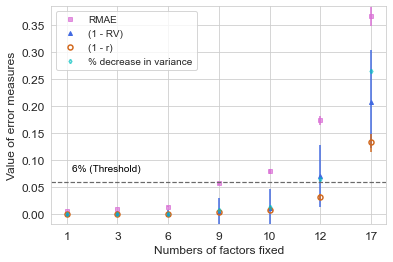

In [47]:

sns.set_style('whitegrid')
fig = plt.figure(figsize=(6, 5))
# form x label
num_in_groups = []

# x_ticklabels = [''] + ['{}{}{}{}'.format(i+1, ' (', (21 - x[i]), ')') for i in range(len(x))]
conf_names = [col for col in METRIC_NAME if '_conf' in col]
colors = ['orchid', 'royalblue','chocolate']
ax = df_metric[METRIC_NAME[:3]].plot(kind='line', yerr=yerror, 
                                    linestyle='', color=colors)

x = df_metric.index
ax.plot(x, df_metric[METRIC_NAME[0]], 's', color=colors[0], ms=4, alpha=0.7, label='RMAE')
ax.plot(x, df_metric[METRIC_NAME[1]], '^', color=colors[1], ms=4, label='RV')
ax.plot(x, df_metric[METRIC_NAME[2]], 'o', ms=5, markerfacecolor='none',label='PPMC',
        markeredgecolor=colors[2], markeredgewidth=1.5)
          
ax.plot(x, variance_frac, 'd', ms=3, markerfacecolor='none',label='First-order variance',
        markeredgecolor='c', markeredgewidth=1.5, alpha=0.7)            
                                                                  
ax.axhline(y=0.06, xmin=0, xmax=6, linestyle='--', linewidth=1.2, color='dimgrey')
ax.tick_params(axis='both', labelsize=12)

ax.set_xlabel('Numbers of factors fixed', fontsize=12)
ax.set_ylabel('Value of error measures', fontsize=12)
# ax.set_ylim(-0.03, 0.5)
# ax.set_xlim(0.85, 7.15)

# ax.set_xticklabels(x_ticklabels)
ax.legend(['RMAE', '(1 - RV)', '(1 - r)', '% decrease in variance'], loc='upper left', fontsize=10)
ax.text(0.1, 0.08, '6% (Threshold)', fontsize=10, color='k')
plt.savefig('{}{}{}'.format('../output/figure/', 'fig7_variance_fix', '.png'), dpi=300, format='png')

## Figure 7

In [13]:
"""Create figure 7 for paper."""
from settings import *

# plot for figure type I
f_dir = ['../output/morris/compare/'+'0.25/',
         '../output/sobol/compare/'+'0.25/']
f_names = ['mae', 'mae_lower','mae_upper']
def f_read(filename):
    df = pd.read_csv(filename)
    df.drop(columns = 'Unnamed: 0', inplace=True)
    df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
    return df

<Figure size 720x432 with 0 Axes>

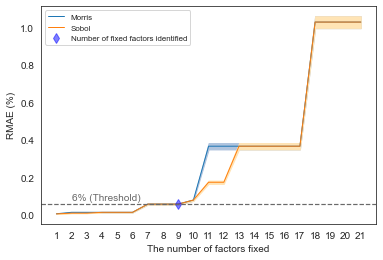

In [19]:


sample_size = ['result_80', 'result_800']
f_morris = f_read(f'{f_dir[0]}{f_names[0]}.csv')
mae_comp = pd.DataFrame(index=f_morris.index)
mae_comp['Morris'] = f_morris[sample_size[0]]
mae_comp['Sobol'] = f_read(f'{f_dir[1]}{f_names[0]}.csv').loc[:, sample_size[1]]
mae_comp['Morris_lower'] = f_read(f'{f_dir[0]}{f_names[1]}.csv').loc[:, sample_size[0]]
mae_comp['Morris_upper'] = f_read(f'{f_dir[0]}{f_names[2]}.csv').loc[:, sample_size[0]]
mae_comp['Sobol_lower'] = f_read(f'{f_dir[1]}{f_names[1]}.csv').loc[:, sample_size[1]]
mae_comp['Sobol_upper'] = f_read(f'{f_dir[1]}{f_names[2]}.csv').loc[:, sample_size[1]]

cols =  mae_comp.columns

fig = plt.figure(figsize=(10, 6))
sns.set_style('white')
palette = plt.get_cmap('Set1')
col_conf = [col for col in cols if '_conf' in col]
ax = mae_comp[cols[0:2]].plot(kind='line', linewidth=1)
ax.fill_between(mae_comp.index, mae_comp['Morris_lower'], 
                mae_comp['Morris_upper'],color='lightsteelblue', label=f'95% CIs for Morris')                
ax.fill_between(mae_comp.index, mae_comp['Sobol_lower'], 
                mae_comp['Sobol_upper'],color='moccasin', label=f'95% CIs for Sobol')

ax.plot(mae_comp['Sobol'][8:9], 'd', color='blue', alpha=0.5, ms=7,
        label='Number of fixed factors identified')
ax.axhline(y=0.06, xmin=0, xmax=21, linestyle='--', linewidth=1.2, color='dimgrey')

ax.set_xticks(range(len(mae_comp)))
ax.set_xticklabels(np.arange(1, 22));
ax.set_xlabel('The number of factors fixed', fontsize=10)
ax.set_ylabel('RMAE (%)', fontsize=10)
leg = ax.legend(['Morris', 'Sobol',
                 'Number of fixed factors identified',
                 ], #'Threshold (6%)','95% CIs for Morris', '95% CIs for Sobol'
                fontsize = 8)
ax.text(1, 0.08, '6% (Threshold)', fontsize=10, color='dimgrey')            
plt.savefig(f'../output/figure/fig7_sa_compare.png', dpi=300, format='png')

## Plot Figure 8

In [89]:
path = '../output/morris/'
f_default = np.append([0, 0.1, 0.4, 0.5], np.linspace(0.2, 0.3, 11))
f_default.sort()
f_default = [round(i, 2) for i in f_default]
# f_default[0] = '0.00'

In [90]:
df = {}
f_read_6 = pd.read_csv('{}{}{}'.format(path, 'fix_6', '.csv'), index_col = 'Unnamed: 0')
f_read_9 = pd.read_csv('{}{}{}'.format(path, 'fix_9', '.csv'),  index_col = 'Unnamed: 0')
for fn in METRIC_NAME:
    df[fn] = pd.DataFrame(columns=['group1', 'group2'], index=f_default)
    for val in f_default:
        df[fn].loc[val, 'group1'] = f_read_6.loc[val, fn]
        df[fn].loc[val, 'group2'] = f_read_9.loc[val, fn]

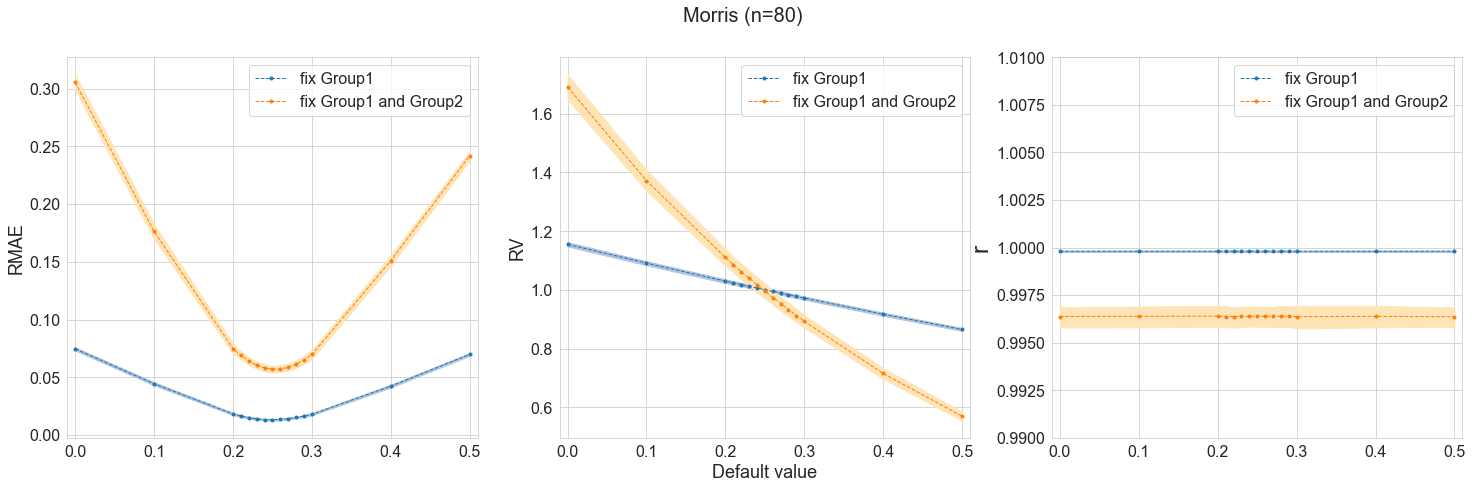

In [91]:

# transform df from dict into dataframe with multiple columns
df = pd.concat(df, axis=1)
df.index = [float(i) for i in df.index]
df=df.astype('float')

def plot_shadow(col_name, ax, ylabel, ylim=None, fs=None):
    df[col_name].plot(kind='line', marker='o', linewidth=1, style='--', ms=3, ax=ax)
    ax.fill_between(df.index, df[f'{col_name}_lower', 'group1'], df[f'{col_name}_upper', 'group1'], color='lightsteelblue')
    ax.fill_between(df.index, df[f'{col_name}_lower', 'group2'], df[f'{col_name}_upper', 'group2'], color='moccasin')
    ax.set_xlim(-0.01, 0.51)
    if not (ylim==None):
        ax.set_ylim(ylim[0], ylim[1])
    ax.tick_params(axis='both', which='major', labelsize=16)
    if fs == None:
        ax.set_ylabel(ylabel, fontsize=18)
    else:
        ax.set_ylabel(ylabel, fontsize=24)    
    ax.legend(['fix Group1', 'fix Group1 and Group2'], fontsize=16)
# End plot_shadow()

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
plot_shadow('mae', axes[0], 'RMAE')
plot_shadow('var', axes[1], 'RV')
fig.suptitle('Morris (n=80)', fontsize=20)
axes[1].set_xlabel('Default value',  fontsize=18)
plot_shadow('ppmc', axes[2], 'r', [0.990, 1.010], 26)

plt.savefig(f'../output/figure/fig8_evaluate_defaults.png', format='png', dpi=300)
